# Определение перспективного тарифа для телеком-компании

# Описание проекта

Компания «Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.<br>
Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов - данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

# Описание тарифов

## Тариф «Смарт»

1. Ежемесячная плата: 550 рублей<br>
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика<br>
3. Стоимость услуг сверх тарифного пакета: <br>- минута разговора: 3 рубля; <br>- сообщение: 3 рубля; <br>- 1 Гб интернет-трафика: 200 рублей.

## Тариф «Ультра»

1. Ежемесячная плата: 1950 рублей<br>
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика<br>
3. Стоимость услуг сверх тарифного пакета: <br>- минута разговора: 1 рубль; <br>- сообщение: 1 рубль; <br>- 1 Гб интернет-трафика: 150 рублей.

# 1. **Изучение данных из файла & предварительная подготовка**

## 1.1. Импорт библиотек

In [1]:
import pandas as pd
import os
from matplotlib import pyplot
import numpy as np
import re
import math
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
from scipy import stats as st

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pyplot.style.use('seaborn-deep')

## 1.2. Откроем локальные или веб-версии файлов данных

1.2.1. напишем функцию поиска файлов из списка на локальном диске или в сети;<br>
1.2.2. после того как файлы найдены, прочтем их, поместив в список датафреймов.

In [2]:
def find(name, path):
    '''
    Function to find the data file stored locally. 
    Takes name of the file and root directory. 
    Scanes the local directory tree for the first orrurance of the file. 
    '''
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)


online_path = 'datasets'
offline_path = '/home/'
file_list = [
    'calls.csv',
    'internet.csv',
    'messages.csv',
    'tariffs.csv',
    'users.csv'
]
df_list = []

for file in file_list:
    try:
        df = pd.read_csv(f'/{online_path}/{file}', index_col=0)
    except FileNotFoundError:
        df = pd.read_csv(find(file, offline_path), index_col=0)
        print(f"Файл {file} найден на локальном диске.")
    else:
        print(f"Файл {file} открыт в режиме online.")
    finally:
        df_list.append(df)

Файл calls.csv найден на локальном диске.
Файл internet.csv найден на локальном диске.
Файл messages.csv найден на локальном диске.
Файл tariffs.csv найден на локальном диске.
Файл users.csv найден на локальном диске.


## 1.3. Получим сводку по каждому датафрейму

In [3]:
start = "\033[1m"
end = "\033[0;0m"
for i in range(0, len(df_list)):
    print(
        f"Размер датафрейма {start}{str(file_list[i]).split('.')[0].upper()}{end}: \
        \nколичество строк - {df_list[i].shape[0]}, \nколичество столбцов - {df_list[i].shape[1]}.")
    print()
    print(
        f"Развернутая сводка датафрейма {start}{str(file_list[i]).split('.')[0].upper()}{end} \nпо наименованию столбцов, типу данных, ненулевых значениях и объему памяти:")
    print()
    df_list[i].info(memory_usage='deep')
    print('--------------------------------------------------------------------')
    print()

Размер датафрейма CALLS:         
количество строк - 202607, 
количество столбцов - 3.

Развернутая сводка датафрейма CALLS 
по наименованию столбцов, типу данных, ненулевых значениях и объему памяти:

<class 'pandas.core.frame.DataFrame'>
Index: 202607 entries, 1000_0 to 1499_219
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   call_date  202607 non-null  object 
 1   duration   202607 non-null  float64
 2   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 28.6 MB
--------------------------------------------------------------------

Размер датафрейма INTERNET:         
количество строк - 149396, 
количество столбцов - 4.

Развернутая сводка датафрейма INTERNET 
по наименованию столбцов, типу данных, ненулевых значениях и объему памяти:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Cou

## 1.4. Поместим полученные датафреймы в соответствующие переменные

In [4]:
calls = df_list[0]
internet = df_list[1]
messages = df_list[2]
tariffs = df_list[3]
users = df_list[4]

## 1.5. Промежуточные выводы и устранение недочетов

### 1.5.1.  Датафрейм **CALLS**

#### a. рассмотрим значения датафрейма

In [5]:
calls.head()

,call_date,duration,user_id
id,,,
1000_0,2018-07-25,0.00,1000
1000_1,2018-08-17,0.00,1000
1000_2,2018-06-11,2.85,1000
1000_3,2018-09-21,13.80,1000
1000_4,2018-12-15,5.18,1000


In [6]:
calls.duration.describe()

count   202607.00
mean         6.76
std          5.84
min          0.00
25%          1.30
50%          6.00
75%         10.70
max         38.00
Name: duration, dtype: float64

#### b. проверим наличие нулевых значений датафрейма

In [7]:
calls.isnull().sum()

call_date    0
duration     0
user_id      0
dtype: int64

#### _Промежуточные выводы_

1. Пропущенные значения отсутствуют. 
2. Столбец **call_date** необходимо перевести в тип данных - дата. 
3. Значения столбца **duration** необходимо округлить до целого в сторону большего для корректных расчетов в дальнейшем.
4. Столбец **id** переименуем в **call_id**.

#### c. Изменение типов данных

In [8]:
calls['call_date'] = pd.to_datetime(calls['call_date'])

In [9]:
# проверим результат изменения: 
calls.dtypes

call_date    datetime64[ns]
duration            float64
user_id               int64
dtype: object

#### d. Переименование столбца **id**

In [11]:
calls = calls.rename(
    columns={
        'id': 'call_id'
    })

In [12]:
# проверим результат изменения: 
calls.columns

Index(['call_date', 'duration', 'user_id'], dtype='object')

### 1.5.2.  Датафрейм **INTERNET**

#### a. рассмотрим значения датафрейма

In [13]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [14]:
internet.mb_used.describe()

count   149396.00
mean       370.19
std        278.30
min          0.00
25%        138.19
50%        348.01
75%        559.55
max       1724.83
Name: mb_used, dtype: float64

#### b. проверим наличие нулевых значений датафрейма

In [15]:
internet.isnull().sum()

id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

#### _Промежуточные выводы_

1. Пропущенные значения отсутствуют. 
2. Столбец **session_date** необходимо перевести в тип данных - дата. 
3. На основании значений столбца **mb_used** создадим столбец **gb_used** с округлением до целого в сторону большего для корректных расчетов в дальнейшем.
4. Столбец **id** переименуем в **session_id**.

#### c. Изменение типов данных

In [16]:
internet['session_date'] = pd.to_datetime(internet['session_date'])

In [17]:
# проверим результат изменения: 
internet.dtypes

id                      object
mb_used                float64
session_date    datetime64[ns]
user_id                  int64
dtype: object

#### d. Переименование столбца **id**

In [19]:
internet = internet.rename(
    columns={
        'id': 'session_id'
    })

In [20]:
# проверим результат изменения: 
internet.columns

Index(['session_id', 'mb_used', 'session_date', 'user_id'], dtype='object')

### 1.5.3.  Датафрейм **MESSAGES**

#### a. рассмотрим значения датафрейма

In [21]:
messages.head()

,message_date,user_id
id,,
1000_0,2018-06-27,1000
1000_1,2018-10-08,1000
1000_2,2018-08-04,1000
1000_3,2018-06-16,1000
1000_4,2018-12-05,1000


#### b. проверим наличие нулевых значений датафрейма

In [22]:
messages.isnull().sum()

message_date    0
user_id         0
dtype: int64

#### _Промежуточные выводы_

1. Пропущенные значения отсутствуют. 
2. Столбец **message_date** необходимо перевести в тип данных - дата. 

#### c. Изменение типов данных

In [23]:
messages['message_date'] = pd.to_datetime(messages['message_date'])

In [24]:
# проверим результат изменения: 
messages.dtypes

message_date    datetime64[ns]
user_id                  int64
dtype: object

### 1.5.4.  Датафрейм **TARIFFS**

#### a. рассмотрим значения датафрейма

In [25]:
display(tariffs)

,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
messages_included,,,,,,,
50,15360,500,550,200,3,3,smart
1000,30720,3000,1950,150,1,1,ultra


In [26]:
# сбросим индекс: 
tariffs.reset_index(inplace=True)

#### b. проверим наличие нулевых значений датафрейма

In [27]:
tariffs.isnull().sum()

messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64

#### _Промежуточные выводы_

1. Пропущенные значения отсутствуют. 
2. Для удобства дальнейших расчетов переведем столбец **mb_per_month_included** из мегабайт в гигабайты и переименуем столбец в **gb_per_month_included**. Также изменим тип данных на цельночисленные значения. 
3. Зададим колонку **tariff_name** в качестве индекса.

#### c. изменение столбца **mb_per_month_included**

In [28]:
# переведем значения столбца в гигабайты в виде целых чисел:
tariffs['mb_per_month_included'] = tariffs.apply(
    lambda x: x.mb_per_month_included / 1024, axis=1).astype(int)

In [29]:
# переименуем столбец:
tariffs = tariffs.rename(
    columns={
        'mb_per_month_included': 'gb_per_month_included'
    })

In [30]:
# обновим индекс: 
tariffs.set_index('tariff_name', inplace=True, drop=False)

### 1.5.5.  Датафрейм **USERS**

#### a. рассмотрим значения датафрейма

In [31]:
users.head()

,age,churn_date,city,first_name,last_name,reg_date,tariff
user_id,,,,,,,
1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


#### b. проверим наличие нулевых значений датафрейма

In [32]:
users.isnull().sum()

age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

#### d. проверим уникальные значения столбцов **city** и **tariff**

In [33]:
users.city.value_counts()

Москва             99
Санкт-Петербург    39
Новосибирск        16
Омск               14
Казань             14
                   ..
Архангельск         1
Иваново             1
Нижневартовск       1
Химки               1
Подольск            1
Name: city, Length: 76, dtype: int64

In [34]:
users.tariff.unique()

array(['ultra', 'smart'], dtype=object)

#### e. проверим значения столбца **age**

Text(0, 0.5, 'Количество пользователей, человек')

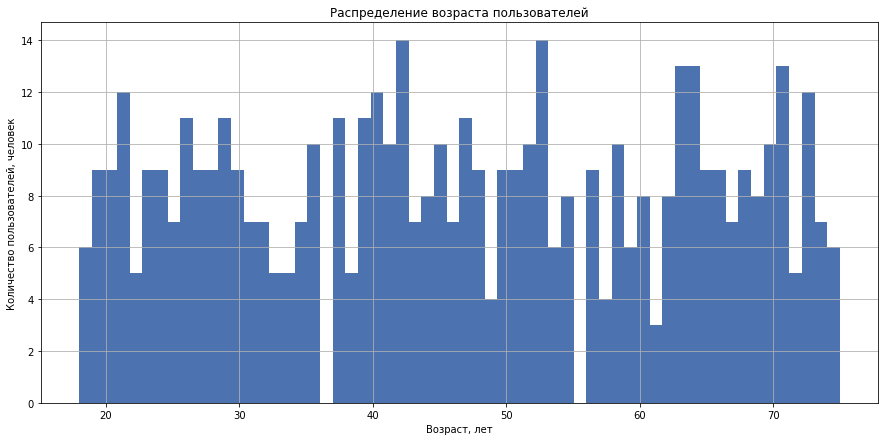

In [35]:
age_plot = users.age.hist(bins=60, figsize=(15, 7))
age_plot.set_title('Распределение возраста пользователей')
age_plot.set_xlabel('Возраст, лет')
age_plot.set_ylabel('Количество пользователей, человек')

#### _Промежуточные выводы_

1. Пропущенные значения присутствуют в столбце **churn_date** (дата прекращения пользования тарифом). Отсутствующее значение свидетельствует о том, что пользователь продолжает пользоваться тарифом на момент выгрузки данных. Поэтому удалять или заменять пропуски не имеет смысла. 
2. Столбцы **reg_date** и **churn_date** необходимо перевести в тип данных - дата. 
3. Возраст пользователей выборки имеет логичный диапазон и количественные всплески в точках 22, 43, 54 63-64, 71 и 74, на которые имеет смысл обратить внимание в процессе анализа. 
4. Столбцы не содержат пропусков или очевидно ошибочных данных. 

#### f. Изменение типов данных

In [36]:
users['reg_date'] = pd.to_datetime(users['reg_date'])

In [37]:
users['churn_date'] = pd.to_datetime(users['churn_date'])

In [38]:
# проверим результат изменения: 
users.dtypes

age                    int64
churn_date    datetime64[ns]
city                  object
first_name            object
last_name             object
reg_date      datetime64[ns]
tariff                object
dtype: object

# 2. **Предобработка данных**

Для анализа данных определим наличие дубликатов и добавим в таблицы **calls, internet, messages, users** столбец месяц, и при помощи сводных таблиц получим количество минут, гигиабайт и смс для каждого пользователя в месяц. <br>
Полученные сводные таблицы объединим в единый датасет - **data_df**, в который добавим данные о тарифе из датафрейма **tariffs**.<br>
В таблице **data_df** проведем вычисления согласно тарифу и фактическому ежемесячному использованию минут, трафика и смс для каждого пользователя. Результатом вычислений должны стать столбцы:<br> 
- **calls_monthly_costs** - стоимость телефонных звонков сверх тарифа для каждого пользователя, 
- **sms_monthly_costs** - стоимость смс сверх тарифа для каждого пользователя, 
- **internet_monthly_costs** - стоимость трафика сверх тарифа для каждого пользователя,
- **monthly_expences** - суммарные расходы каждого пользователя с учетом ежемесячной стоимости пакета и расходов сверх лимита.

Таблицу **data_df** объединим с таблицей **users** в датафрейм **df** для дальнейшего статистического анализа. 

## 2.1. Округление значений столбца **duration** таблицы **CALLS**

In [39]:
calls['duration'] = np.ceil(calls['duration'])

In [40]:
# проверим полученный результат:
calls.head(5)

,call_date,duration,user_id
id,,,
1000_0,2018-07-25,0.00,1000
1000_1,2018-08-17,0.00,1000
1000_2,2018-06-11,3.00,1000
1000_3,2018-09-21,14.00,1000
1000_4,2018-12-15,6.00,1000


## 2.2. Поиск дубликатов

Исходя из специфики рассматриваемых датасетов рассмотрим наличие дубликатов в датафреймах **calls, internet, messages** и **users**.

In [41]:
calls[calls.duplicated()]

,call_date,duration,user_id
id,,,
1000_72,2018-12-21,3.00,1000
1000_79,2018-06-17,0.00,1000
1000_184,2018-08-17,0.00,1000
1000_204,2018-09-25,13.00,1000
1000_205,2018-05-31,0.00,1000
...,...,...,...
1499_119,2018-10-21,0.00,1499
1499_146,2018-10-03,0.00,1499
1499_155,2018-10-16,0.00,1499


In [42]:
internet[internet.duplicated()]

,session_id,mb_used,session_date,user_id


In [43]:
messages[messages.duplicated()]

,message_date,user_id
id,,
1000_16,2018-06-25,1000
1000_26,2018-07-29,1000
1000_32,2018-07-07,1000
1000_36,2018-08-15,1000
1000_37,2018-12-07,1000
...,...,...
1499_179,2018-12-12,1499
1499_180,2018-09-28,1499
1499_181,2018-09-27,1499


In [44]:
users[users.duplicated()]

,age,churn_date,city,first_name,last_name,reg_date,tariff
user_id,,,,,,,


#### _Промежуточные выводы_

Все датафреймы свободны от дубликатов. 

## 2.3. Добавление столбца месяц в датафреймы **CALLS, INTERNET, MESSAGES и USERS**

In [45]:
calls['month'] = calls['call_date'].dt.to_period('m')

In [46]:
# проверим полученный результат:
calls.head()

,call_date,duration,user_id,month
id,,,,
1000_0,2018-07-25,0.00,1000,2018-07
1000_1,2018-08-17,0.00,1000,2018-08
1000_2,2018-06-11,3.00,1000,2018-06
1000_3,2018-09-21,14.00,1000,2018-09
1000_4,2018-12-15,6.00,1000,2018-12


In [47]:
internet['month'] = internet['session_date'].dt.to_period('m')

In [48]:
# проверим полученный результат:
internet.head()

,session_id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,2018-11
1,1000_1,1052.81,2018-09-07,1000,2018-09
2,1000_2,1197.26,2018-06-25,1000,2018-06
3,1000_3,550.27,2018-08-22,1000,2018-08
4,1000_4,302.56,2018-09-24,1000,2018-09


In [49]:
messages['month'] = messages['message_date'].dt.to_period('m')

In [50]:
# проверим полученный результат:
messages.head()

,message_date,user_id,month
id,,,
1000_0,2018-06-27,1000,2018-06
1000_1,2018-10-08,1000,2018-10
1000_2,2018-08-04,1000,2018-08
1000_3,2018-06-16,1000,2018-06
1000_4,2018-12-05,1000,2018-12


In [51]:
users['reg_month'] = users['reg_date'].dt.to_period('m')

In [52]:
users['churn_month'] = users['churn_date'].dt.to_period('m')

In [53]:
# проверим полученный результат:
users.head()

,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,churn_month
user_id,,,,,,,,,
1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05,NaT
1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,2018-11,NaT
1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,2018-06,NaT
1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,2018-08,NaT
1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,2018-05,NaT


## 2.4. Получение сводных таблиц с данными по каждому пользователю в месяц

In [54]:
calls_pivot = calls.pivot_table(index=['user_id','month'], values='duration', aggfunc='sum')

In [55]:
calls_pivot = calls_pivot.rename(
    columns={
        'duration': 'minutes_used',
    })

In [56]:
# проверим полученный результат:
calls_pivot.head(12)

minutes_used
user_id month                
1000    2018-05        159.00
        2018-06        172.00
        2018-07        340.00
        2018-08        408.00
        2018-09        466.00
        2018-10        350.00
        2018-11        338.00
        2018-12        333.00
1001    2018-11        430.00
        2018-12        414.00
1002    2018-06        117.00
        2018-07        214.00

In [57]:
calls_pivot.minutes_used.describe()

count   3174.00
mean     456.93
std      238.03
min        0.00
25%      290.00
50%      447.00
75%      592.00
max     1673.00
Name: minutes_used, dtype: float64

In [58]:
internet_pivot = internet.pivot_table(index=['user_id', 'month'],
                                      values='mb_used',
                                      aggfunc='sum')

In [59]:
# переведем трафик в гигабайты и округлим данные до единицы вверх, заменим тип данных на цельночисленный:
internet_pivot['gb_used'] = np.ceil(internet_pivot.mb_used / 1024).astype(int)

In [60]:
# проверим полученный результат:
internet_pivot.head(12)

mb_used  gb_used
user_id month                    
1000    2018-05  2253.49        3
        2018-06 23233.77       23
        2018-07 14003.64       14
        2018-08 14055.93       14
        2018-09 14568.91       15
        2018-10 14702.49       15
        2018-11 14756.47       15
        2018-12  9817.61       10
1001    2018-11 18429.34       18
        2018-12 14036.66       14
1002    2018-06 10856.82       11
        2018-07 17580.10       18

In [61]:
internet_pivot.gb_used.describe()

count   3203.00
mean      17.36
std        7.34
min        0.00
25%       13.00
50%       17.00
75%       21.00
max       49.00
Name: gb_used, dtype: float64

In [62]:
messages_pivot = messages.reset_index().pivot_table(
    index=['user_id', 'month'], 
    values='id', 
    aggfunc='count').astype(int)

In [63]:
messages_pivot = messages_pivot.rename(
    columns={
        'id': 'sms_used',
    })

In [64]:
# проверим полученный результат:
messages_pivot.head(12)

sms_used
user_id month            
1000    2018-05        22
        2018-06        60
        2018-07        75
        2018-08        81
        2018-09        57
        2018-10        73
        2018-11        58
        2018-12        70
1002    2018-06         4
        2018-07        11
        2018-08        13
        2018-09         4

In [65]:
messages_pivot.sms_used.describe()

count   2717.00
mean      45.28
std       35.05
min        1.00
25%       19.00
50%       38.00
75%       63.00
max      224.00
Name: sms_used, dtype: float64

Рассмотрим размер полученных сводных таблиц. 

In [66]:
calls_pivot.shape

(3174, 1)

In [67]:
internet_pivot.shape

(3203, 2)

In [68]:
messages_pivot.shape

(2717, 1)

## 2.5. Объединение сводных таблиц в **DATA_DF**

In [69]:
data_df = calls_pivot.merge(
    right=internet_pivot, 
    how='outer', 
    left_index=True, 
    right_on=['user_id', 'month']
)

In [70]:
data_df = data_df.merge(right=messages_pivot, 
                        how='outer',
                        left_index=True, 
                        right_on=['user_id', 'month']
                       )

In [71]:
# проверим полученный результат:
data_df.head(12)

minutes_used  mb_used  gb_used  sms_used
user_id month                                            
1000    2018-05        159.00  2253.49     3.00     22.00
        2018-06        172.00 23233.77    23.00     60.00
        2018-07        340.00 14003.64    14.00     75.00
        2018-08        408.00 14055.93    14.00     81.00
        2018-09        466.00 14568.91    15.00     57.00
        2018-10        350.00 14702.49    15.00     73.00
        2018-11        338.00 14756.47    15.00     58.00
        2018-12        333.00  9817.61    10.00     70.00
1001    2018-11        430.00 18429.34    18.00       NaN
        2018-12        414.00 14036.66    14.00       NaN
1002    2018-06        117.00 10856.82    11.00      4.00
        2018-07        214.00 17580.10    18.00     11.00

In [72]:
# проверим размер полученного объединенного датафрейма:
data_df.shape

(3214, 4)

Так как часть пользователей могла не отправлять смс или не пользоваться интернетом/звонками в какие-то периоды, то предположу наличие пропусков в объединенной таблице. Если таковые имеются, заменяем на 0. 

In [73]:
data_df.isnull().sum()

minutes_used     40
mb_used          11
gb_used          11
sms_used        497
dtype: int64

In [74]:
data_df.fillna(0, inplace=True)

In [75]:
# проверим полученный результат: 
data_df.isnull().sum()

minutes_used    0
mb_used         0
gb_used         0
sms_used        0
dtype: int64

In [76]:
# вернем тип данных столбцов к цельночисленному: 
data_df = data_df[['minutes_used', 'gb_used', 'sms_used']].astype(int)

In [77]:
# сбросим индекс: 
data_df.reset_index(inplace=True)

In [78]:
# проверим полученный результат: 
data_df.head(5)

,user_id,month,minutes_used,gb_used,sms_used
0,1000,2018-05,159,3,22
1,1000,2018-06,172,23,60
2,1000,2018-07,340,14,75
3,1000,2018-08,408,14,81
4,1000,2018-09,466,15,57


In [79]:
data_df.query('minutes_used > 0').shape[0] == calls_pivot.query('minutes_used > 0').shape[0]

True

In [80]:
data_df.query('gb_used > 0').shape[0] == internet_pivot.query('gb_used > 0').shape[0]

True

In [81]:
data_df.query('sms_used > 0').shape[0] == messages_pivot.query('sms_used > 0').shape[0]

True

## 2.6. Объединение таблиц **DATA_DF** и **USERS**

In [82]:
df = data_df.merge(right=users, how='inner', left_on=['user_id'], right_on=['user_id'])

In [83]:
# проверим полученный результат: 
df.head(5)

,user_id,month,minutes_used,gb_used,sms_used,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,churn_month
0,1000,2018-05,159,3,22,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05,NaT
1,1000,2018-06,172,23,60,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05,NaT
2,1000,2018-07,340,14,75,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05,NaT
3,1000,2018-08,408,14,81,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05,NaT
4,1000,2018-09,466,15,57,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05,NaT


In [84]:
# добавим столбец категории capital, содержащий в бинарной форме данные о том, находится ли пользователь в столице или нет: 
df['is_capital'] = (df['city'] == 'Москва').astype(int)

In [85]:
# рассмотрим общее количество пользователей в столице и за ее пределами:
df.is_capital.value_counts()

0    2603
1     611
Name: is_capital, dtype: int64

In [86]:
# добавим столбец категории tariff, содержащий в бинарной форме данные о том, какой тариф использует пользователь: 
df['tariff_name'] = (df['tariff'] == 'smart').astype(int)

In [87]:
# рассмотрим общее количество пользователей каждого тарифа:
df.tariff_name.value_counts()

1    2229
0     985
Name: tariff_name, dtype: int64

In [88]:
# проверим размер полученного датафрейма: 
df.shape

(3214, 16)

In [89]:
# получим список колонок нового датафрейма: 
df.columns

Index(['user_id', 'month', 'minutes_used', 'gb_used', 'sms_used', 'age',
       'churn_date', 'city', 'first_name', 'last_name', 'reg_date', 'tariff',
       'reg_month', 'churn_month', 'is_capital', 'tariff_name'],
      dtype='object')

## 2.7. Расчёты и добавление результатов в таблицу **DF**

Напишем функцию расчета ежемесячных расходов в зависимости от тарифа и фактически использованных минут, гигабайтов и смс: 


In [90]:
def tariff_calculator(row):
    tariff = row['tariff']
    payment = tariffs.loc[tariff, 'rub_monthly_fee']

    if row['minutes_used'] > tariffs.loc[tariff, 'minutes_included']:
        payment += (row['minutes_used'] -
                    tariffs.loc[tariff, 'minutes_included']
                    ) * tariffs.loc[tariff, 'rub_per_minute']
    if row['gb_used'] > tariffs.loc[tariff, 'gb_per_month_included']:
        payment += (row['gb_used'] -
                    tariffs.loc[tariff, 'gb_per_month_included']
                    ) * tariffs.loc[tariff, 'rub_per_gb']
    if row['sms_used'] > tariffs.loc[tariff, 'messages_included']:
        payment += (row['sms_used'] - tariffs.loc[tariff, 'messages_included']
                    ) * tariffs.loc[tariff, 'rub_per_message']
    row['actual_payment'] = payment
    return row

In [91]:
# применим полученную функцию к сводному датафрейму:
df = df.apply(tariff_calculator, axis=1)

In [92]:
# проверим полученный результат:
df.head(5)

,user_id,month,minutes_used,gb_used,sms_used,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,churn_month,is_capital,tariff_name,actual_payment
0,1000,2018-05,159,3,22,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05,NaT,0,0,1950
1,1000,2018-06,172,23,60,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05,NaT,0,0,1950
2,1000,2018-07,340,14,75,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05,NaT,0,0,1950
3,1000,2018-08,408,14,81,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05,NaT,0,0,1950
4,1000,2018-09,466,15,57,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05,NaT,0,0,1950


In [93]:
# проверим столбец actual_payment на наличие пропусков:
df.actual_payment.isnull().sum()

0

In [94]:
# получим статистическое описание данных по столбцу actual_payment:
df.actual_payment.describe()

count   3214.00
mean    1529.08
std      798.25
min      550.00
25%      750.00
50%     1653.50
75%     1950.00
max     6770.00
Name: actual_payment, dtype: float64

Text(0.5, 0, 'Ежемесячные затраты, руб.')

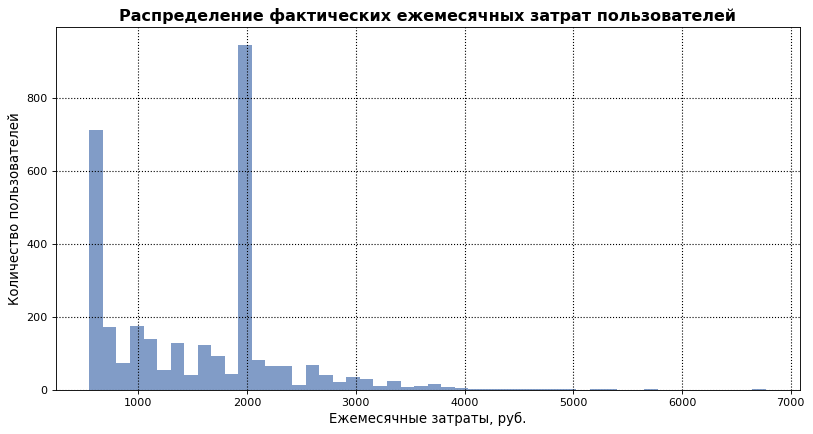

In [95]:
payments_plot = df.actual_payment

figure(figsize=(12, 6), dpi=80)
pyplot.grid(color='black', 
            linestyle="dotted", 
            linewidth=1)
pyplot.hist(payments_plot, 
            bins=50, 
            alpha=0.7)
pyplot.title(label='Распределение фактических ежемесячных затрат пользователей', 
             fontdict={'fontsize': 'x-large',
                       'fontweight': 'semibold'})
pyplot.ylabel("Количество пользователей", 
              fontsize='large')
pyplot.xlabel("Ежемесячные затраты, руб.", 
              fontsize='large')

#### _Промежуточные выводы_

Распределение фактических затрат пользователей указывает на наличие двух всплесков по количеству пользователей в районе значений фиксированного ежемесячного платежа для двух тарифов. Что указывает на наличие достаточно большой доли пользователей, которые используют только минуты/смс/трафик, входящие в пакет тарифа. <br>
Кром того, имеются выбросы по размеру затрат в месяц, существенно превышающие затраты большинства пользователей - в диапазоне от 4000 до 7000 руб.

# 3. **Анализ данных**

## 3.1. Средние значения использования минут, смс и трафика по каждому тарифу. 

Создадим две выборки согласно тарифам, имеющегося датафрейма.

In [96]:
ultra_df = df.query('tariff_name == 0')

In [97]:
# найдем количество пользователей данного тарифа:
ultra_df.user_id.nunique()

148

In [98]:
smart_df = df.query('tariff_name == 1')

In [99]:
# найдем количество пользователей данного тарифа:
smart_df.user_id.nunique()

350

In [100]:
# расчитаем среднее количество звонков, смс и интернет соединений пользователей тарифа Ультра: 
ultra_df[['minutes_used', 'gb_used', 'sms_used']].mean()

minutes_used   526.62
gb_used         19.49
sms_used        49.36
dtype: float64

In [101]:
# расчитаем среднее количество звонков, смс и интернет соединений пользователей тарифа Смарт: 
smart_df[['minutes_used', 'gb_used', 'sms_used']].mean()

minutes_used   417.93
gb_used         16.33
sms_used        33.38
dtype: float64

In [102]:
# расчитаем дисперсию для звонков, смс и интернет соединений пользователей тарифа Ультра:
np.var(ultra_df[['minutes_used', 'gb_used', 'sms_used']], axis = 0)

minutes_used   100771.22
gb_used            96.99
sms_used         2282.95
dtype: float64

In [103]:
# расчитаем дисперсию для звонков, смс и интернет соединений пользователей тарифа Смарт:
np.var(smart_df[['minutes_used', 'gb_used', 'sms_used']], axis = 0)

minutes_used   36203.07
gb_used           33.01
sms_used         796.46
dtype: float64

In [104]:
# расчитаем стандартное отклонение для звонков, смс и интернет соединений пользователей тарифа Смарт:
np.std(ultra_df[['minutes_used', 'gb_used', 'sms_used']], axis = 0)

minutes_used   317.44
gb_used          9.85
sms_used        47.78
dtype: float64

In [105]:
# расчитаем стандартное отклонение для звонков, смс и интернет соединений пользователей тарифа Ультра:
np.std(smart_df[['minutes_used', 'gb_used', 'sms_used']], axis = 0)

minutes_used   190.27
gb_used          5.75
sms_used        28.22
dtype: float64

array([[<AxesSubplot:xlabel='minutes_used', ylabel='minutes_used'>,
        <AxesSubplot:xlabel='gb_used', ylabel='minutes_used'>,
        <AxesSubplot:xlabel='sms_used', ylabel='minutes_used'>,
        <AxesSubplot:xlabel='tariff_name', ylabel='minutes_used'>],
       [<AxesSubplot:xlabel='minutes_used', ylabel='gb_used'>,
        <AxesSubplot:xlabel='gb_used', ylabel='gb_used'>,
        <AxesSubplot:xlabel='sms_used', ylabel='gb_used'>,
        <AxesSubplot:xlabel='tariff_name', ylabel='gb_used'>],
       [<AxesSubplot:xlabel='minutes_used', ylabel='sms_used'>,
        <AxesSubplot:xlabel='gb_used', ylabel='sms_used'>,
        <AxesSubplot:xlabel='sms_used', ylabel='sms_used'>,
        <AxesSubplot:xlabel='tariff_name', ylabel='sms_used'>],
       [<AxesSubplot:xlabel='minutes_used', ylabel='tariff_name'>,
        <AxesSubplot:xlabel='gb_used', ylabel='tariff_name'>,
        <AxesSubplot:xlabel='sms_used', ylabel='tariff_name'>,
        <AxesSubplot:xlabel='tariff_name', ylabel='tari

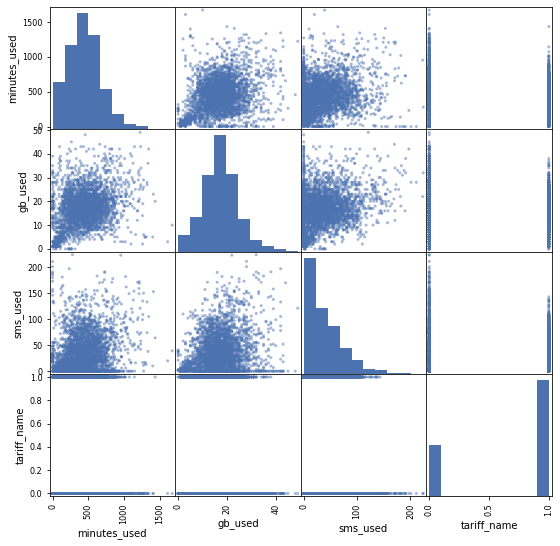

In [106]:
# рассмотрим корреляцию расхода минут, смс и трафика в зависимости от тарифа пользователя: 
pd.plotting.scatter_matrix(df[['minutes_used', 'gb_used', 'sms_used', 'tariff_name']],
                           figsize=(9, 9))

1. Пользователей тарифа Смарт почти в три раза больше, чем пользователей тарифа Ультра. 
2. Пользователи тарифа Ультра в основном используют больше трафика, смс и минут разговоров, чем пользователи тарифа Смарт. 
3. Графически можно увидеть положительную корреляцию между объемом используемого трафика и минутами разговора. 
4. Предположение, что пользователи, использующие больше трафика меньше пользуются смс, не потдверждается графиком.   

In [107]:
# создадим сводную таблицу средних значений для тарифа Ультра по месяцам: 
ultra_avg_monthly_usage = ultra_df.pivot_table(
    index=['month'], 
    values=['minutes_used', 'gb_used', 'sms_used'], 
    aggfunc='mean')

In [108]:
# создадим сводную таблицу средних значений для тарифа Смарт по месяцам: 
smart_avg_monthly_usage = smart_df.pivot_table(
    index=['month'], 
    values=['minutes_used', 'gb_used', 'sms_used'], 
    aggfunc='mean')

In [128]:
# сравним средние значения между собой:
comparison = round(
    (ultra_avg_monthly_usage / smart_avg_monthly_usage) * 100).astype(int)

In [129]:
display(comparison)

,gb_used,minutes_used,sms_used
month,,,
2018-01,151,210,185
2018-02,101,99,91
2018-03,116,126,101
2018-04,125,125,103
2018-05,122,132,112
2018-06,119,121,125
2018-07,129,134,148
2018-08,117,121,144
2018-09,117,126,155


#### _Промежуточные выводы_

В основном пользователи тарифа **Ультра** используют больше минут и смс, нежели пользователи тарифа **Смарт**. Однако, пользователи тарифа **Смарт** используют больше интернет трафика по сравнению с пользователями тарифа **Ультра**.<br>
Высокие показатели стандартного отклонения для минут и смс пользователей тарифа **Смарт** говорят о наличии в выборке пользователей с расходом, значительно превышающем средние значения. 

### 3.1.1. Анализ среднего использования минут

Text(0.5, 0, 'Месяц')

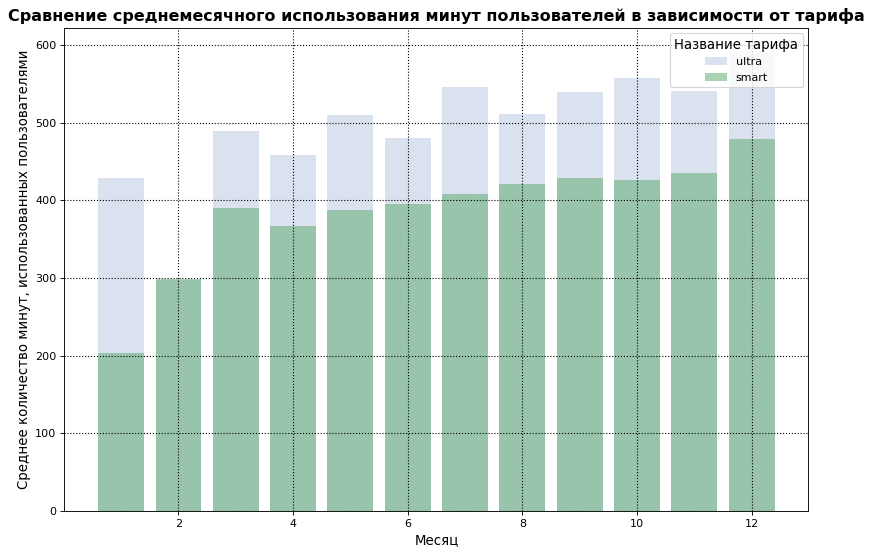

In [111]:
# построим график использования времени разговоров в среднем по месяцам в зависимости от тарифа: 
minutes_total_ultra_plot = ultra_avg_monthly_usage["minutes_used"]
minutes_total_smart_plot = smart_avg_monthly_usage["minutes_used"]
labels =  ultra_avg_monthly_usage.index.month
figure(figsize=(12, 8), dpi=80)
pyplot.grid(color='black', 
            linestyle="dotted", 
            linewidth=1)
pyplot.bar(labels, minutes_total_ultra_plot, 
            alpha=0.2, 
            label='ultra')
pyplot.bar(labels, minutes_total_smart_plot, 
            alpha=0.5, 
            label='smart')
pyplot.title(label='Сравнение среднемесячного использования минут пользователей в зависимости от тарифа', 
             fontdict={'fontsize': 'x-large',
                       'fontweight': 'semibold'})
pyplot.legend(title='Название тарифа',
              title_fontsize='large', 
              loc='upper right')
pyplot.ylabel("Среднее количество минут, использованных пользователями", 
              fontsize='large')
pyplot.xlabel("Месяц", 
              fontsize='large')

#### _Промежуточные выводы_

Использование минут для двух тарифов имеет тенденцию к росту в течение года с минимальными значениями в январе-феврале. <br>Пользователи тарифа **Ультра** используют больше минут разговоров по сравнению с пользователями тарифа **Смарт**. <br>В феврале пользователи двух тарифов использовали одинаковое количество минут. 

### 3.1.2. Анализ среднего использования СМС

Text(0.5, 0, 'Месяц')

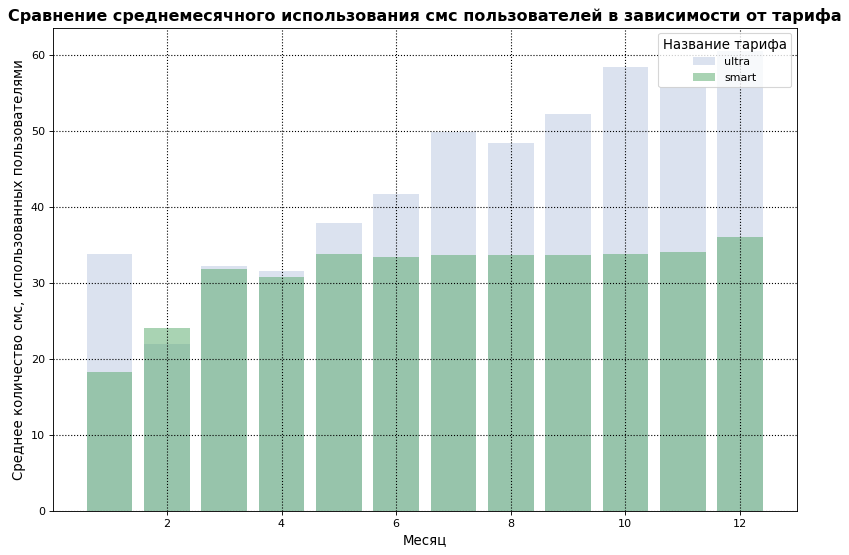

In [112]:
# построим график использования смс в среднем по месяцам в зависимости от тарифа: 
sms_total_ultra_plot = ultra_avg_monthly_usage["sms_used"]
sms_total_smart_plot = smart_avg_monthly_usage["sms_used"]
labels =  ultra_avg_monthly_usage.index.month
figure(figsize=(12, 8), dpi=80)
pyplot.grid(color='black', 
            linestyle="dotted", 
            linewidth=1)
pyplot.bar(labels, sms_total_ultra_plot, 
            alpha=0.2, 
            label='ultra')
pyplot.bar(labels, sms_total_smart_plot, 
            alpha=0.5, 
            label='smart')
pyplot.title(label='Сравнение среднемесячного использования смс пользователей в зависимости от тарифа', 
             fontdict={'fontsize': 'x-large',
                       'fontweight': 'semibold'})
pyplot.legend(title='Название тарифа',
              title_fontsize='large', 
              loc='upper right')
pyplot.ylabel("Среднее количество смс, использованных пользователями", 
              fontsize='large')
pyplot.xlabel("Месяц", 
              fontsize='large')

#### _Промежуточные выводы_

Как и для минут, использование смс для двух тарифов имеет тенденцию к росту в течение года, однако  минимальные значения фиксируются в периоде с января по апрель. В этот же период (за исключением января) разрыв между пользователями двух тарифов минимален. <br>Пользователи тарифа **Ультра** также используют больше смс по сравнению с пользователями тарифа **Смарт**. <br>В феврале пользователи тарифа **Смарт** опередили пользователей тарифа **Ультра** по количеству отправленных смс.

### 3.1.3. Анализ среднего использования интернет трафика

Text(0.5, 0, 'Месяц')

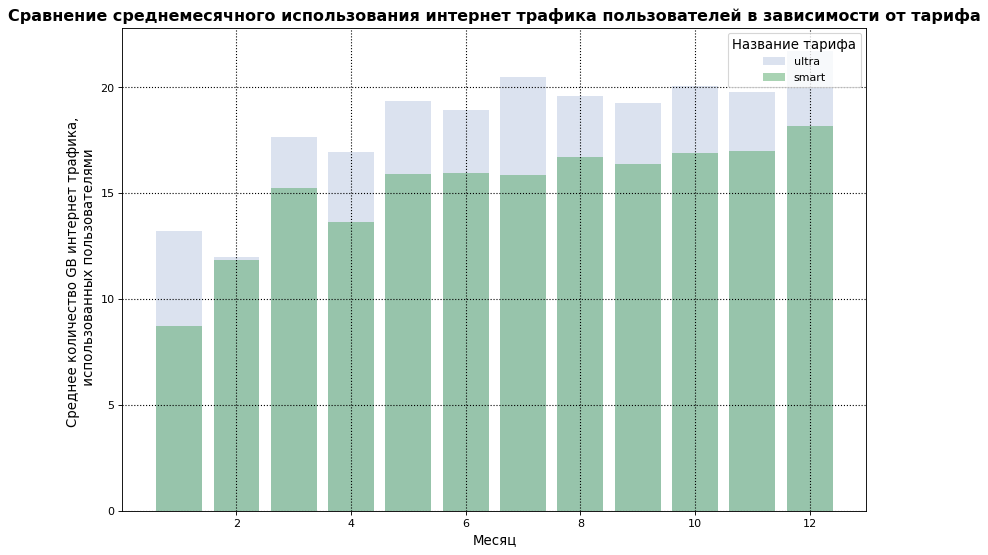

In [113]:
# построим график использования смс в среднем по месяцам в зависимости от тарифа: 
gb_total_ultra_plot = ultra_avg_monthly_usage["gb_used"]
gb_total_smart_plot = smart_avg_monthly_usage["gb_used"]
labels =  ultra_avg_monthly_usage.index.month
figure(figsize=(12, 8), dpi=80)
pyplot.grid(color='black', 
            linestyle="dotted", 
            linewidth=1)
pyplot.bar(labels, gb_total_ultra_plot, 
            alpha=0.2, 
            label='ultra')
pyplot.bar(labels, gb_total_smart_plot, 
            alpha=0.5, 
            label='smart')
pyplot.title(label='Сравнение среднемесячного использования интернет трафика пользователей в зависимости от тарифа', 
             fontdict={'fontsize': 'x-large',
                       'fontweight': 'semibold'})
pyplot.legend(title='Название тарифа',
              title_fontsize='large', 
              loc='upper right')
pyplot.ylabel("Среднее количество GB интернет трафика, \n использованных пользователями", 
              fontsize='large')
pyplot.xlabel("Месяц", 
              fontsize='large')

#### _Промежуточные выводы_

Использование трафика для двух тарифов также имеет тенденцию к росту в течение года, однако данный рост менее выражен. Минимумы фиксируются в январе-феврале. <br>Пользователи тарифа **Ультра** используют больше трафика по сравнению с пользователями тарифа **Смарт**. <br>В феврале пользователи двух тарифов использовали примерно одинаковое количество гигабайт. 

## 3.2. Анализ потребительского поведения пользователей

### 3.2.1. Анализ использования минут пользователями

Text(0.5, 0, 'Расход минут пользователя в месяц')

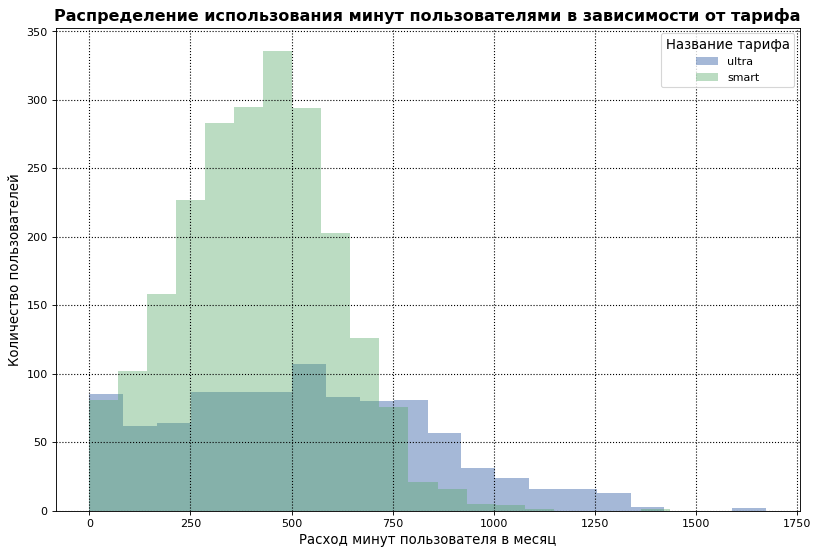

In [114]:
ultra_plot = ultra_df.minutes_used
smart_plot = smart_df.minutes_used

figure(figsize=(12, 8), dpi=80)
pyplot.grid(color='black', 
            linestyle="dotted", 
            linewidth=1)
pyplot.hist(ultra_plot, 
            bins=20, 
            alpha=0.5, 
            label='ultra')
pyplot.hist(smart_plot, 
            bins=20, 
            alpha=0.4, 
            label='smart')
pyplot.title(label='Распределение использования минут пользователями в зависимости от тарифа', 
             fontdict={'fontsize': 'x-large',
                       'fontweight': 'semibold'})
pyplot.legend(title='Название тарифа',
              title_fontsize='large', 
              loc='upper right')
pyplot.ylabel("Количество пользователей", 
              fontsize='large')
pyplot.xlabel("Расход минут пользователя в месяц", 
              fontsize='large')

#### _Промежуточные выводы_

Пользователи тарифа **Смарт** в подавляющем большинстве остаются в пределах 500 минут по пакету тарифа. <br>Пользователи тарифа **Ультра** не выбирают 3000 минут, включенные в тариф. 

In [115]:
# проверим совпадение среднего и медианы: 

print(f'Среднее для тарифа Ультра: {ultra_df.minutes_used.mean()}')
print(f'Медиана для тарифа Ультра: {ultra_df.minutes_used.median()}')
print(f'Среднее для тарифа Смарт: {smart_df.minutes_used.mean()}')
print(f'Медиана для тарифа Смарт: {smart_df.minutes_used.median()}')

Среднее для тарифа Ультра: 526.6233502538071
Медиана для тарифа Ультра: 518.0
Среднее для тарифа Смарт: 417.9349484073576
Медиана для тарифа Смарт: 422.0


Оба графика имеют нормальное распределение. Распределение тарифа Ультра незначительно скошено вправо, а тарифа Смарт - влево. 

### 3.2.2. Анализ использования смс пользователями

Text(0.5, 0, 'Расход смс пользователя в месяц')

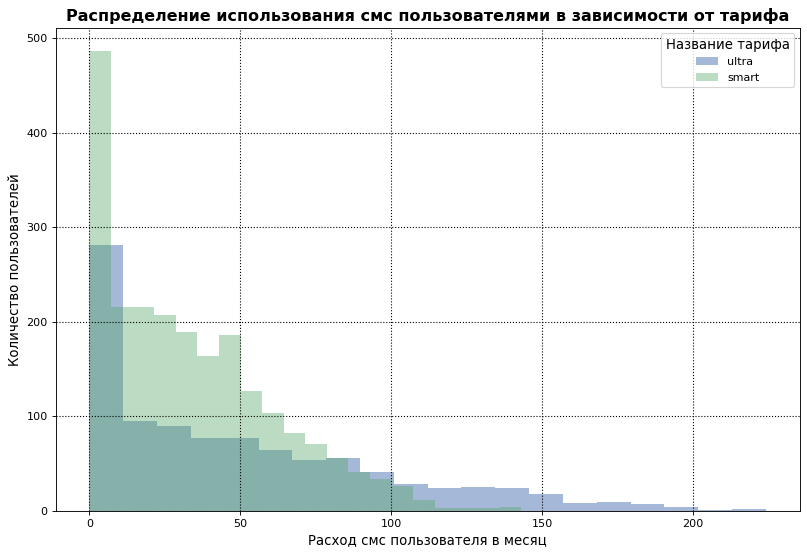

In [116]:
ultra_plot = ultra_df.sms_used
smart_plot = smart_df.sms_used

figure(figsize=(12, 8), dpi=80)
pyplot.grid(color='black', 
            linestyle="dotted", 
            linewidth=1)
pyplot.hist(ultra_plot, 
            bins=20, 
            alpha=0.5, 
            label='ultra')
pyplot.hist(smart_plot, 
            bins=20, 
            alpha=0.4, 
            label='smart')
pyplot.title(label='Распределение использования смс пользователями в зависимости от тарифа', 
             fontdict={'fontsize': 'x-large',
                       'fontweight': 'semibold'})
pyplot.legend(title='Название тарифа',
              title_fontsize='large', 
              loc='upper right')
pyplot.ylabel("Количество пользователей", 
              fontsize='large')
pyplot.xlabel("Расход смс пользователя в месяц", 
              fontsize='large')

In [117]:
# проверим совпадение среднего и медианы: 

print(f'Среднее для тарифа Ультра: {ultra_df.sms_used.mean()}')
print(f'Медиана для тарифа Ультра: {ultra_df.sms_used.median()}')
print(f'Среднее для тарифа Смарт: {smart_df.sms_used.mean()}')
print(f'Медиана для тарифа Смарт: {smart_df.sms_used.median()}')

Среднее для тарифа Ультра: 49.36345177664975
Медиана для тарифа Ультра: 38.0
Среднее для тарифа Смарт: 33.384028712427096
Медиана для тарифа Смарт: 28.0


#### _Промежуточные выводы_

Оба графика скошены вправо.<br>
Для пользователей обоих тарифов характерен всплеск в диапазоне значений от 0 до 10 - т.е. количество пользователей не использующих или почти не использующих смс достаточно велико. <br>
Доля пользователей тарифа **Смарт**, превышающих лимит в 50 смс достаточна велика. <br>
Пользователи тарифа **Ультра** не выбирают пакет в 1000 смс даже в единичных случаях.  

### 3.2.3. Анализ использования интернет трафика пользователями

Text(0.5, 0, 'Расход трафика пользователя в месяц, ГБ')

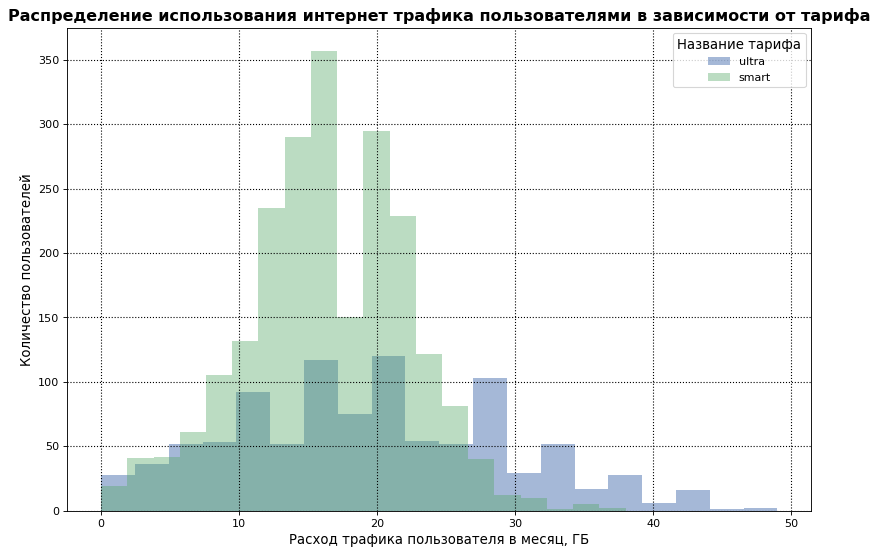

In [118]:
ultra_plot = ultra_df.gb_used
smart_plot = smart_df.gb_used

figure(figsize=(12, 8), dpi=80)
pyplot.grid(color='black', 
            linestyle="dotted", 
            linewidth=1)
pyplot.hist(ultra_plot, 
            bins=20, 
            alpha=0.5, 
            label='ultra')
pyplot.hist(smart_plot, 
            bins=20, 
            alpha=0.4, 
            label='smart')
pyplot.title(label='Распределение использования интернет трафика пользователями в зависимости от тарифа', 
             fontdict={'fontsize': 'x-large',
                       'fontweight': 'semibold'})
pyplot.legend(title='Название тарифа',
              title_fontsize='large', 
              loc='upper right')
pyplot.ylabel("Количество пользователей", 
              fontsize='large')
pyplot.xlabel("Расход трафика пользователя в месяц, ГБ", 
              fontsize='large')

In [119]:
# проверим совпадение среднего и медианы: 

print(f'Среднее для тарифа Ультра: {ultra_df.gb_used.mean()}')
print(f'Медиана для тарифа Ультра: {ultra_df.gb_used.median()}')
print(f'Среднее для тарифа Смарт: {smart_df.gb_used.mean()}')
print(f'Медиана для тарифа Смарт: {smart_df.gb_used.median()}')

Среднее для тарифа Ультра: 19.494416243654822
Медиана для тарифа Ультра: 19.0
Среднее для тарифа Смарт: 16.328847016599372
Медиана для тарифа Смарт: 17.0


#### _Промежуточные выводы_

Оба графика имеют нормальное распределение. Распределение тарифа Смарт незначительно скошено влево.<br>
Пользователи обоих тарифов превышают лимиты по интернет трафику (15 и 30 Гб соответственно). <br>
При этом доля пользователей тарифа **Смарт**, превысивших свой лимит, гораздо выше, нежели доля таких пользователей тарифа **Ультра**. <br>
Оба графика показывают пиковые значения в районе 15 и 20 Гб.<br>

### 3.2.4. Анализ фактических расходов пользователей

Получим статистическое описание данных по столбцу actual_payment для обеих выборок. 

In [120]:
ultra_df.actual_payment.describe()

count    985.00
mean    2070.15
std      376.19
min     1950.00
25%     1950.00
50%     1950.00
75%     1950.00
max     4800.00
Name: actual_payment, dtype: float64

In [121]:
smart_df.actual_payment.describe()

count   2229.00
mean    1289.97
std      818.40
min      550.00
25%      550.00
50%     1023.00
75%     1750.00
max     6770.00
Name: actual_payment, dtype: float64

Построим диаграмму распределения ежемесячных затрат пользователей в зависимости от тарифа. 

Text(0.5, 0, 'Расход пользователя в месяц, руб.')

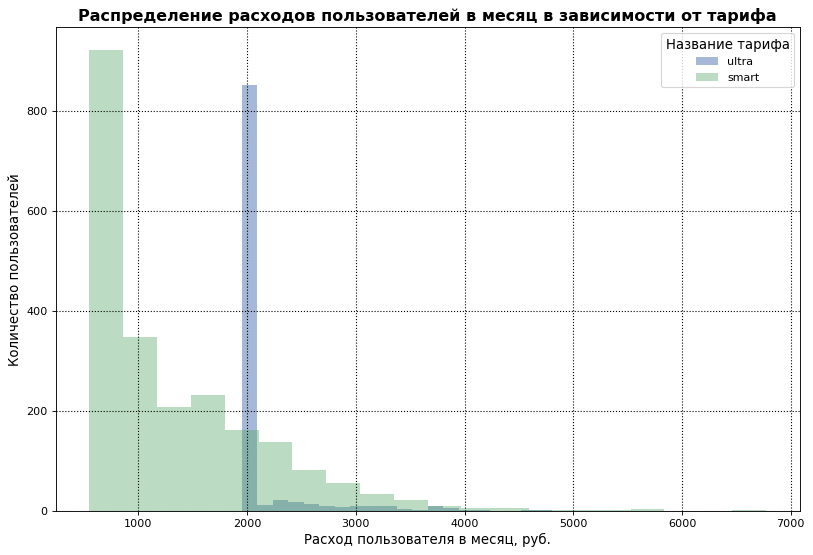

In [130]:
ultra_plot = ultra_df.actual_payment
smart_plot = smart_df.actual_payment

figure(figsize=(12, 8), dpi=80)
pyplot.grid(color='black', 
            linestyle="dotted", 
            linewidth=1)
pyplot.hist(ultra_plot, 
            bins=20, 
            alpha=0.5, 
            label='ultra')
pyplot.hist(smart_plot, 
            bins=20, 
            alpha=0.4, 
            label='smart')
pyplot.title(label='Распределение расходов пользователей в месяц в зависимости от тарифа', 
             fontdict={'fontsize': 'x-large',
                       'fontweight': 'semibold'})
pyplot.legend(title='Название тарифа',
              title_fontsize='large', 
              loc='upper right')
pyplot.ylabel("Количество пользователей", 
              fontsize='large')
pyplot.xlabel("Расход пользователя в месяц, руб.", 
              fontsize='large')

In [123]:
# проверим совпадение среднего и медианы: 

print(f'Среднее для тарифа Ультра: {ultra_df.actual_payment.mean()}')
print(f'Медиана для тарифа Ультра: {ultra_df.actual_payment.median()}')
print(f'Среднее для тарифа Смарт: {smart_df.actual_payment.mean()}')
print(f'Медиана для тарифа Смарт: {smart_df.actual_payment.median()}')

Среднее для тарифа Ультра: 2070.1522842639592
Медиана для тарифа Ультра: 1950.0
Среднее для тарифа Смарт: 1289.9735307312696
Медиана для тарифа Смарт: 1023.0


#### _Промежуточные выводы_

График распределения затрат пользователей тарифа **Ультра** скошен вправо, пользователей тарифа **Смарт** - влево.<br>
Затраты на услуги связи по обоим тарифам показывают пиковые значения для пользователей, которые предпочитают не выходить за рамки лимитов по тарифу. При этом среди пользователей тарифа **Ультра** таких подавляющее большинство, а значит для компании средний пользователь тарифа **Смарт** выгоднее, т.к. он чаще будет превышать лимиты по тарифу, тем более с учетом численного перевеса пользователей тарифа **Смарт**. 

Text(0.5, 0, 'Расход пользователя в месяц, руб.')

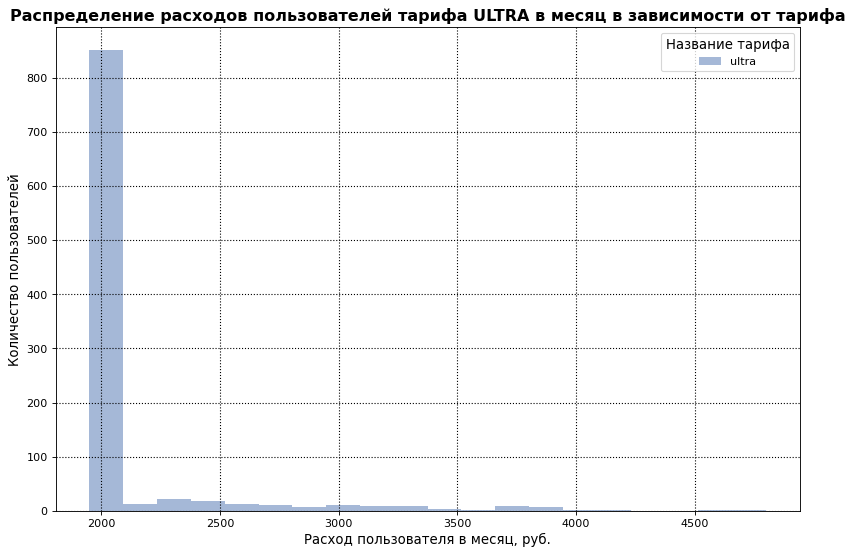

In [131]:
ultra_plot = ultra_df.actual_payment

figure(figsize=(12, 8), dpi=80)
pyplot.grid(color='black', 
            linestyle="dotted", 
            linewidth=1)
pyplot.hist(ultra_plot, 
            bins=20, 
            alpha=0.5, 
            label='ultra')
pyplot.title(label='Распределение расходов пользователей тарифа ULTRA в месяц в зависимости от тарифа', 
             fontdict={'fontsize': 'x-large',
                       'fontweight': 'semibold'})
pyplot.legend(title='Название тарифа',
              title_fontsize='large', 
              loc='upper right')
pyplot.ylabel("Количество пользователей", 
              fontsize='large')
pyplot.xlabel("Расход пользователя в месяц, руб.", 
              fontsize='large')

Text(0.5, 0, 'Расход пользователя в месяц, руб.')

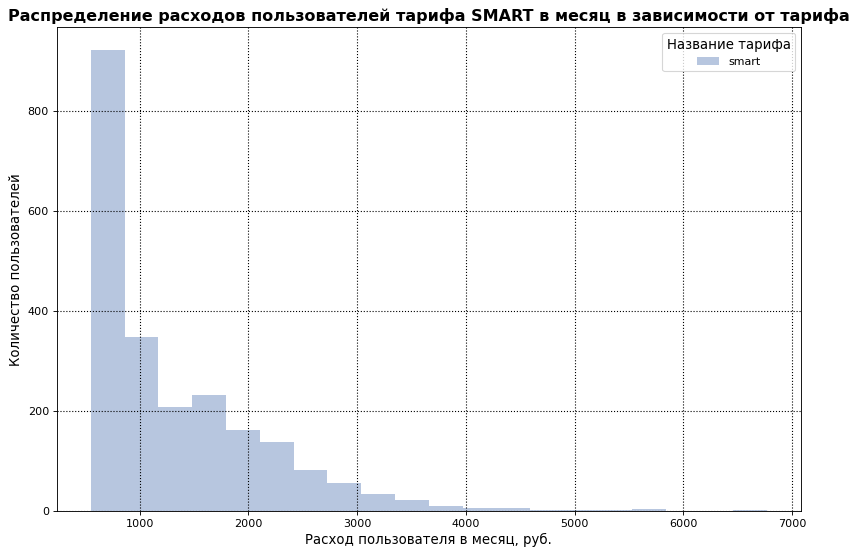

In [132]:
smart_plot = smart_df.actual_payment

figure(figsize=(12, 8), dpi=80)
pyplot.grid(color='black', 
            linestyle="dotted", 
            linewidth=1)
pyplot.hist(smart_plot, 
            bins=20, 
            alpha=0.4, 
            label='smart')
pyplot.title(label='Распределение расходов пользователей тарифа SMART в месяц в зависимости от тарифа', 
             fontdict={'fontsize': 'x-large',
                       'fontweight': 'semibold'})
pyplot.legend(title='Название тарифа',
              title_fontsize='large', 
              loc='upper right')
pyplot.ylabel("Количество пользователей", 
              fontsize='large')
pyplot.xlabel("Расход пользователя в месяц, руб.", 
              fontsize='large')

## 3.3. Проверка гипотезы о равенстве средней выручки пользователей тарифов **Ультра** и **Смарт**

**Нулевая гипотеза**: средняя выручка пользователей тарифов одинакова. <br>
**Альтернативная гипотеза**: средняя выручка пользователей тарифов различается.

In [126]:
sample_1 = ultra_df['actual_payment']
sample_2 = smart_df['actual_payment']

alpha = .05  # критический уровень статистической значимости, если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(
    sample_1,
    sample_2,
    equal_var=False  # т.к. размеры выборок отличаются
)

print('p-значение: ', round(results.pvalue, 10))

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.0
Отвергаем нулевую гипотезу


## 3.4. Проверка гипотезы о равенстве средней выручки пользователей, проживающих в столице и за ее пределами

**Нулевая гипотеза**: средняя выручка пользователей в столице совпадает с выручкой пользователей за пределами столицы. <br>
**Альтернативная гипотеза**: средняя выручка пользователей различается в зависимости от нахождения в столичном регионе.

In [127]:
sample_1 = df.query("is_capital == 1")['actual_payment']
sample_2 = df.query("is_capital == 0")['actual_payment']

alpha = .05  # критический уровень статистической значимости, если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(
    sample_1,
    sample_2,
    equal_var=False  # т.к. размеры выборок отличаются примерно в 4 раза
)

print('p-значение: ', round(results.pvalue, 10))

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.5257376664
Не получилось отвергнуть нулевую гипотезу


# 4. **Общий вывод**

Ввиду того, что проверка гипотезы о равенстве средних затрат пользователя вне зависимости от тарифа не подтвердилась, тариф **Смарт** должен быть признан более выгодным для оператора, т.к. несмотря на низкую стоимость ежемесячной платы (благодаря чему количество пользователей данного тарифа выше), пользователи данного тарифа склонны к перерасходу наиболее значимой статьи расхода - интернет-трафика. <br>
Потребительское поведение пользователей в столице не отличается от поведенческого поведения пользователей за пределами столицы.  